# 1. Import Packages & Module 

In [2]:
import pandas as pandas
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn as sns 
from sklearn.model_selection import  train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
import cv2
import os


In [3]:
# about dataset 
# classes : 30 different types of crops 
# total images : 829 

# 2. Create CNN Model 

In [4]:
def sequential_cnn_model(input_size = (128,128,3)):
    classifier_model = Sequential()
    classifier_model.add(Conv2D(256, kernel_size=(5,5), input_shape = input_size, activation='relu'))
    classifier_model.add(MaxPooling2D(pool_size=(3,3)))

    classifier_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    classifier_model.add(MaxPooling2D(pool_size=(2,2)))

    classifier_model.add(Conv2D(64, kernel_size=(2,2), activation='relu'))
    classifier_model.add(MaxPooling2D(pool_size=(2,2)))

    classifier_model.add(Flatten())
    classifier_model.add(Dense(units=30,activation='softmax'))
    
    print(classifier_model.summary())
    classifier_model.compile(optimizer=keras.optimizers.Adam() ,loss=keras.metrics.categorical_crossentropy, metrics=['accuracy'])
    return classifier_model 


In [5]:
classifier_cnn_model = sequential_cnn_model()

/Users/aadityaraj/Projects/deep_learning/cnn/image_classification/cnn_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 256)  │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 41, 41, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 39, 39, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │       155,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 502,878 (1.92 MB)

 Trainable params: 502,878 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

None


# 3. Prepare Data 

In [6]:
# Prepare the data generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 20% validation split

data_dir = '/Users/aadityaraj/Projects/deep_learning/cnn/image_classification/crops_classifications/Agricultural-crops'
image_size = (128,128)
batch_size = 128

# Load training data
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # 
    subset='training'  # This is for the training data
)

# Load validation data
val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # This is for the validation data
)

Found 674 images belonging to 30 classes.
Found 155 images belonging to 30 classes.


# 4. Train CNN Model 

In [7]:
# # Train the model using the generators
# classifier_cnn_model.fit(
#     train_gen,
#     epochs=20,
#     validation_data=val_gen
# )

# # Optionally save the model after training
# classifier_cnn_model.save('crop_classifier_cnn_model.h5')

# 5. Evaluate Model 

In [8]:
# Evaluate the model on the test data
test_loss, test_accuracy = classifier_cnn_model.evaluate(val_gen)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

/Users/aadityaraj/Projects/deep_learning/cnn/image_classification/cnn_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.0250 - loss: 3.3963
Test Accuracy: 2.58%


# 6.Prediction for real and new data (images of crop)

In [16]:
def inference(image_path,class_names):

    # Load the model
    model = tf.keras.models.load_model('crop_classifier_cnn_model.h5')

    # Define the target size that the model was trained on
    image_size = (128, 128)

    # List of class names
    class_names = class_names

    # Load and preprocess the image
    img = load_img(image_path, target_size=image_size)  # Resize image to match model input size
    img_array = img_to_array(img)  # Convert image to a NumPy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (model expects a batch of images)
    img_array = img_array / 255.0  # Normalize image to the range [0, 1] (same as during training)

    # Predict using the model
    predictions = model.predict(img_array)

    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Get the predicted class name
    predicted_class = class_names[predicted_class_index]

    # Print the result
    print(f"Predicted class: {predicted_class}")
    print(f"Prediction probabilities: {predictions}")

    return predicted_class,predictions


# 7. Show Crop Image 

In [20]:
def show_img(image_path):
    img = cv2.imread(image_path)

    # OpenCV loads images in BGR format, so we need to convert it to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

# 8. Get Final Prediction for given image & Visualisation

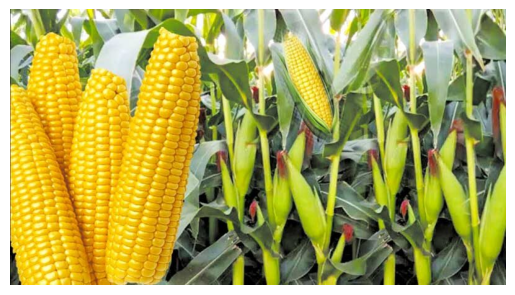

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted class: maize
Prediction probabilities: [[2.6479949e-10 3.9891238e-10 8.9043689e-11 9.8712510e-11 2.8880641e-11
  4.9205639e-15 1.9321968e-09 2.6759245e-10 4.2355967e-12 5.3533322e-06
  3.0830068e-15 7.4032162e-11 2.2247668e-10 6.7983488e-13 1.8379712e-16
  1.8770541e-10 5.5471020e-07 4.9440129e-13 9.9957794e-01 1.6621685e-07
  7.6103457e-10 1.1114243e-10 3.4155612e-04 5.4794706e-05 1.1589944e-17
  1.9266550e-05 8.0438128e-11 2.8479656e-16 1.4474525e-16 5.0265038e-07]]


('maize',
 array([[2.6479949e-10, 3.9891238e-10, 8.9043689e-11, 9.8712510e-11,
         2.8880641e-11, 4.9205639e-15, 1.9321968e-09, 2.6759245e-10,
         4.2355967e-12, 5.3533322e-06, 3.0830068e-15, 7.4032162e-11,
         2.2247668e-10, 6.7983488e-13, 1.8379712e-16, 1.8770541e-10,
         5.5471020e-07, 4.9440129e-13, 9.9957794e-01, 1.6621685e-07,
         7.6103457e-10, 1.1114243e-10, 3.4155612e-04, 5.4794706e-05,
         1.1589944e-17, 1.9266550e-05, 8.0438128e-11, 2.8479656e-16,
         1.4474525e-16, 5.0265038e-07]], dtype=float32))

In [23]:
# Path to your new image
image_path = '/Users/aadityaraj/Projects/deep_learning/cnn/image_classification/crops_classifications/Agricultural-crops/maize/image (4).jpg'
class_names = sorted(os.listdir(data_dir))
show_img(image_path)
inference(image_path,class_names)